## <B><center>Model Training</center></B>

### Import Necessary Libraries

In [ ]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from collections import Counter
from imblearn.combine import SMOTETomek
from multiprocessing import Pool, cpu_count
import time


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

### Importing the Data

In [9]:
df = pd.read_csv('data/cleaned_data.csv')

#### Let us take a look at the top 5 rows of the data

In [10]:
df.head()

,Applicant_Income,Loan_Amount,Credit_Score,Previous_Defaults,Interest_Rate,Loan_Purpose,Number_of_Dependents,Residence_Status,Home_Ownership,Employment_Type,Default
0,141958,38905,558,2,4.77,Medical,4,Rented,Own,Retired,0
1,35795,32103,402,2,14.59,Personal,4,Mortgaged,Rent,Unemployed,0
2,20860,41188,400,4,10.05,Personal,0,Mortgaged,Mortgage,Salaried,0
3,123694,10845,497,2,12.67,Personal,1,Rented,Mortgage,Retired,1
4,148106,26162,525,4,8.70,Education,4,Mortgaged,Own,Retired,0


#### Let us verify the column data types

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Applicant_Income      5000 non-null   int64  
 1   Loan_Amount           5000 non-null   int64  
 2   Credit_Score          5000 non-null   int64  
 3   Previous_Defaults     5000 non-null   int64  
 4   Interest_Rate         5000 non-null   float64
 5   Loan_Purpose          5000 non-null   object 
 6   Number_of_Dependents  5000 non-null   int64  
 7   Residence_Status      5000 non-null   object 
 8   Home_Ownership        5000 non-null   object 
 9   Employment_Type       5000 non-null   object 
 10  Default               5000 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 429.8+ KB


### Let us analyze the distribution of the target variable

In [66]:
df['Default'].value_counts()

Default
0    3496
1    1504
Name: count, dtype: int64

#### The analysis above indicates that the target variable is imbalanced, with a disproportionate distribution of the classes. To address this imbalance, we will apply SMOTE (Synthetic Minority Oversampling Technique) to generate synthetic samples and balance the dataset effectively.

#### Next, we will define the independent and dependent variables, categorize the data into numerical and categorical features, and preprocess it by encoding categorical features and scaling numerical features. Finally, we will apply resampling techniques to balance the target variable.

In [78]:
# Separate features and target
X = df.drop(columns=['Default'])
y = df['Default']

# Identify feature types
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numerical features:", num_features)
print("Categorical features:", cat_features)

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first'), cat_features)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Fit-transform only on training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Apply SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_train_new, y_train_new = smote_tomek.fit_resample(X_train_preprocessed, y_train)

print("Class distribution before:", Counter(y_train))
print("Class distribution after:", Counter(y_train_new))


Numerical features: ['Applicant_Income', 'Loan_Amount', 'Credit_Score', 'Previous_Defaults', 'Interest_Rate', 'Number_of_Dependents']
Categorical features: ['Loan_Purpose', 'Residence_Status', 'Home_Ownership', 'Employment_Type']
Class distribution before: Counter({0: 2797, 1: 1203})
Class distribution after: Counter({0: 2725, 1: 2725})


### Creating a function to evaluate the models

In [79]:
def evaluate_model(true, predicted, proba=None):
    acc = accuracy_score(true, predicted)
    f1 = f1_score(true, predicted)
    roc = roc_auc_score(true, proba if proba is not None else predicted)
    fpr, tpr, thresholds = roc_curve(true, proba if proba is not None else predicted)
    return acc, f1, roc, fpr, tpr, thresholds

### Let us train and evaluate the models and store the results in a dataframe

In [92]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

# Define classification models
models = {
    "Logistic Regression": LogisticRegression(),
    "KNeighbors": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "SVC": SVC(probability=True),
    "DecisionTree": DecisionTreeClassifier()
}

# Create DataFrames to store the results
train_results = pd.DataFrame(columns=['Model', 'Accuracy', 'F1 Score', 'ROC AUC'])
test_results = pd.DataFrame(columns=['Model', 'Accuracy', 'F1 Score', 'ROC AUC'])



# Train and evaluate models
for model_name, model in models.items():
    print(f"Training {model_name}...")

    model.fit(X_train_new, y_train_new)

    train_pred = model.predict(X_train_new)
    test_pred = model.predict(X_test_preprocessed)

    # Use predicted probabilities for ROC AUC
    train_proba = model.predict_proba(X_train_new)[:, 1] if hasattr(model, "predict_proba") else None
    test_proba = model.predict_proba(X_test_preprocessed)[:, 1] if hasattr(model, "predict_proba") else None

    train_acc, train_f1, train_roc, train_fpr, train_tpr, train_thresh = evaluate_model(y_train_new, train_pred, train_proba)
    test_acc, test_f1, test_roc, test_fpr, test_tpr, test_thresh = evaluate_model(y_test, test_pred, test_proba)

    train_results.loc[len(train_results)] = [model_name, train_acc, train_f1, train_roc]
    test_results.loc[len(test_results)] = [model_name, test_acc, test_f1, test_roc]


Training Logistic Regression...
Training KNeighbors...
Training RandomForest...
Training AdaBoost...
Training GradientBoosting...
Training XGBoost...
Training SVC...
Training DecisionTree...


#### These are the training results

In [94]:
train_results = train_results.sort_values(by='Accuracy', ascending=False)
train_results

,Model,Accuracy,F1 Score,ROC AUC
2,RandomForest,1.000000,1.000000,1.000000
7,DecisionTree,1.000000,1.000000,1.000000
5,XGBoost,0.973394,0.972708,0.998894
1,KNeighbors,0.801468,0.826436,0.926472
4,GradientBoosting,0.793578,0.742032,0.877848
6,SVC,0.757064,0.768207,0.840505
3,AdaBoost,0.683670,0.638574,0.754361
0,Logistic Regression,0.531927,0.532869,0.556152


#### These are the test results

In [95]:
test_results = test_results.sort_values(by='Accuracy', ascending=False)
test_results

,Model,Accuracy,F1 Score,ROC AUC
4,GradientBoosting,0.693,0.025397,0.477288
2,RandomForest,0.667,0.125984,0.502210
5,XGBoost,0.651,0.212190,0.512978
3,AdaBoost,0.631,0.254545,0.508845
7,DecisionTree,0.581,0.333863,0.514905
6,SVC,0.527,0.313498,0.488386
0,Logistic Regression,0.507,0.357236,0.511965
1,KNeighbors,0.487,0.361146,0.472757


#### Looking at the above results, some modles like Random Forest, Gradient Boosting and Decision Trees are overfitting the model. Let us try to tune the hyperparameters of these models and see if we can improve their performance.

In [101]:
param_grids = {
    "Logistic Regression": {
        'model': LogisticRegression(),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'solver': ['liblinear', 'lbfgs', 'saga'],
            'penalty': ['l1', 'l2', 'elasticnet', 'none'],
            'max_iter': [100, 200, 300]
        }
    },
    "KNN": {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski'],
            'p': [1, 2]
        }
    },
    "Decision Tree": {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': [5, 10, 15, 20, None],
            'criterion': ['gini', 'entropy', 'log_loss'],
            'splitter': ['best', 'random'],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    "Random Forest": {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'bootstrap': [True, False]
        }
    },
    "AdaBoost": {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.5, 1.0]
        }
    },
    "Gradient Boosting": {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [100, 150, 200],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 4, 5],
            'subsample': [0.8, 1.0],
            'min_samples_split': [2, 5]
        }
    },
    "SVC": {
        'model': SVC(probability=True),
        'params': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto'],
            'degree': [3, 4, 5]
        }
    },
    "XGBoost": {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'gamma': [0, 0.1, 0.2]
        }
    }
}

### Now, we will hyperparameter tune the models using GridSearchCV to find the best hyperparameters for each model

In [102]:
# Create results DataFrames
train_results = pd.DataFrame(columns=['Model', 'Accuracy', 'F1 Score', 'ROC AUC'])
test_results = pd.DataFrame(columns=['Model', 'Accuracy', 'F1 Score', 'ROC AUC'])
best_params_df = pd.DataFrame(columns=['Model', 'Best Parameters'])

# Loop through each model in the param_grids dictionary
for model_name, config in param_grids.items():
    print(f"\n🔍 Tuning and training {model_name}...")

    model = config['model']
    param_grid = config['params']

    grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
    grid.fit(X_train_new, y_train_new)

    best_model = grid.best_estimator_
    best_params = grid.best_params_
    print(f"✅ Best Parameters for {model_name}: {best_params}")

    # Predictions
    train_pred = best_model.predict(X_train_new)
    test_pred = best_model.predict(X_test_preprocessed)

    # Probabilities for ROC AUC
    train_proba = best_model.predict_proba(X_train_new)[:, 1] if hasattr(best_model, "predict_proba") else None
    test_proba = best_model.predict_proba(X_test_preprocessed)[:, 1] if hasattr(best_model, "predict_proba") else None

    # Evaluation
    train_acc, train_f1, train_roc, *_ = evaluate_model(y_train_new, train_pred, train_proba)
    test_acc, test_f1, test_roc, *_ = evaluate_model(y_test, test_pred, test_proba)

    # Store results
    train_results.loc[len(train_results)] = [model_name, train_acc, train_f1, train_roc]
    test_results.loc[len(test_results)] = [model_name, test_acc, test_f1, test_roc]
    best_params_df.loc[len(best_params_df)] = [model_name, best_params]



🔍 Tuning and training Logistic Regression...


✅ Best Parameters for Logistic Regression: {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}

🔍 Tuning and training KNN...
✅ Best Parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

🔍 Tuning and training Decision Tree...
✅ Best Parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}

🔍 Tuning and training Random Forest...
✅ Best Parameters for Random Forest: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

🔍 Tuning and training AdaBoost...
✅ Best Parameters for AdaBoost: {'learning_rate': 1.0, 'n_estimators': 200}

🔍 Tuning and training Gradient Boosting...
✅ Best Parameters for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 150, 'subsample': 0.8}

🔍 Tuning and training SVC...
✅ Best Parameters for SVC: {'C': 10, 'degree': 5, 'gamma': 's

/mnt/d/Online Learning/06. Data Science & Analytics Extras/06. Machine Learning Projects/02. Neo Finance Loan Default/ldenv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:04:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/mnt/d/Online Learning/06. Data Science & Analytics Extras/06. Machine Learning Projects/02. Neo Finance Loan Default/ldenv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:04:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/mnt/d/Online Learning/06. Data Science & Analytics Extras/06. Machine Learning Projects/02. Neo Finance Loan Default/ldenv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:04:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration

✅ Best Parameters for XGBoost: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


In [103]:
train_results = train_results.sort_values(by='Accuracy', ascending=False)
train_results

,Model,Accuracy,F1 Score,ROC AUC
1,KNN,1.000000,1.000000,1.000000
3,Random Forest,1.000000,1.000000,1.000000
6,SVC,0.986055,0.986197,0.999263
2,Decision Tree,0.931927,0.929077,0.989983
5,Gradient Boosting,0.789174,0.736407,0.867225
7,XGBoost,0.785138,0.728872,0.866437
4,AdaBoost,0.758899,0.709934,0.807752
0,Logistic Regression,0.540734,0.545982,0.556307


In [107]:
test_results = test_results.sort_values(by='Accuracy', ascending=False)
test_results

,Model,Accuracy,F1 Score,ROC AUC
5,Gradient Boosting,0.693,0.025397,0.490563
7,XGBoost,0.693,0.019169,0.472113
3,Random Forest,0.674,0.094444,0.498738
4,AdaBoost,0.666,0.102151,0.502410
2,Decision Tree,0.593,0.279646,0.473921
6,SVC,0.546,0.297214,0.483605
1,KNN,0.542,0.318452,0.489974
0,Logistic Regression,0.522,0.377604,0.510544


As per the above results, we can see that Gradient Boosting is the best models with accuracy of 69.3% and ROC AUC of 0.49. So, let us choose **Gradient Boosting** as our final model.

In [108]:
best_params_df[best_params_df['Model'] == 'Gradient Boosting']['Best Parameters'].values[0]

{'learning_rate': 0.05,
 'max_depth': 3,
 'min_samples_split': 5,
 'n_estimators': 150,
 'subsample': 0.8}

accuracy Score:  0.693
f1 Score:  0.025396825396825397
              precision    recall  f1-score   support

           0       0.70      0.99      0.82       699
           1       0.29      0.01      0.03       301

    accuracy                           0.69      1000
   macro avg       0.49      0.50      0.42      1000
weighted avg       0.57      0.69      0.58      1000



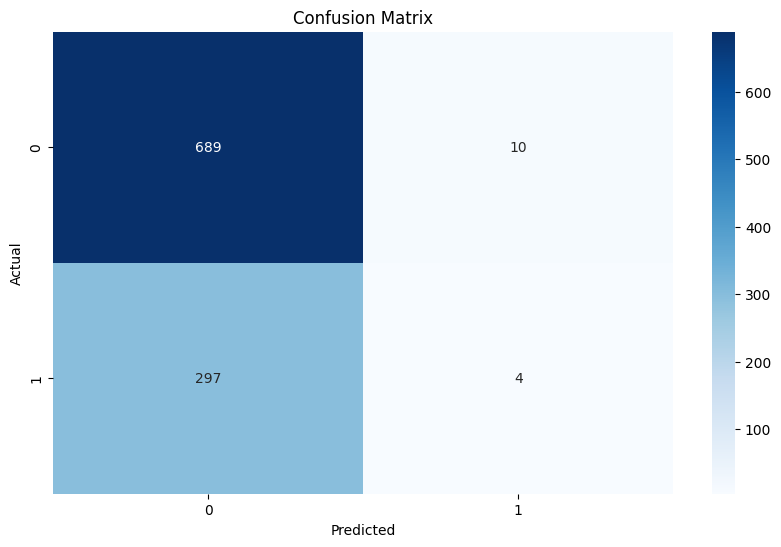

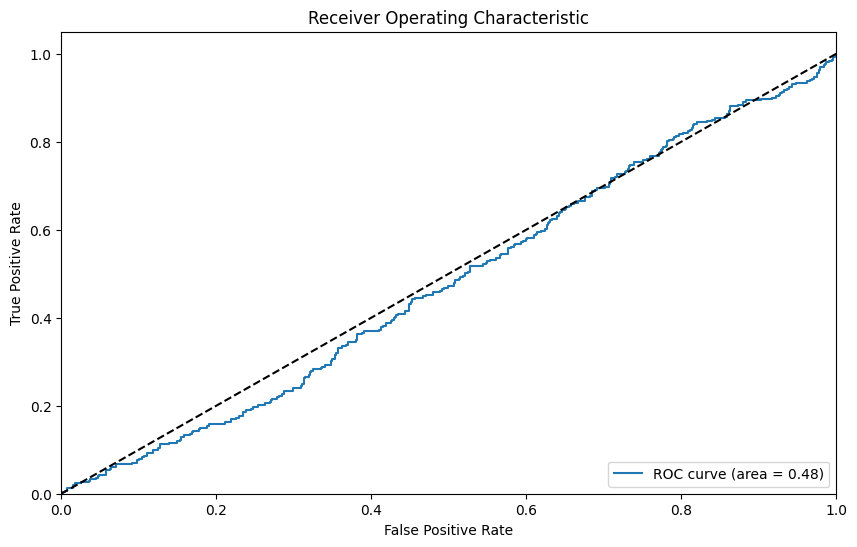

In [110]:
model = GradientBoostingClassifier(learning_rate= 0.05, max_depth= 3, min_samples_split= 5, n_estimators= 150, subsample= 0.8)
model.fit(X_train_new, y_train_new)
y_pred = model.predict(X_test_preprocessed)
y_pred_proba = model.predict_proba(X_test_preprocessed)[:, 1]
print("accuracy Score: ", accuracy_score(y_test, y_pred))
print("f1 Score: ", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred_proba))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

### Let us save the model as a pickle file

In [111]:
import os
import pickle

# Ensure the directory exists
os.makedirs('models', exist_ok=True)

# Save the preprocessor
with open('models/preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

# Save the trained model
with open('models/model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Preprocessor and model saved successfully!")

Preprocessor and model saved successfully!
